# Installs

In [ ]:
!pip install tensorflow==2.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.1 MB 7.1 kB/s 
     |████████████████████████████████| 438 kB 77.2 MB/s 
     |████████████████████████████████| 1.7 MB 58.6 MB/s 
     |████████████████████████████████| 5.9 MB 71.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully 

In [ ]:
pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# GDrive connection

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/HMWK2

/gdrive/.shortcut-targets-by-id/12JPPVxLkWQkx591Su9530FzjA6jNjEnR/HMWK2


# Imports

In [ ]:
from focal_loss import SparseCategoricalFocalLoss
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import *
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from numpy.random import default_rng
from sklearn.utils import class_weight
tfk = tf.keras
tfkl = tf.keras.layers


# Env Setup

In [ ]:
# Fixed random seed to make results as reproducible as possible
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data loading - preprocessing

## Functions for time series 2 image conversion

This function is used to normalize an array between 0 and 255 using NumPy library. Here's how it works:

The function takes an input array as an argument.
- For each row (i.e., first dimension) of the input array, the function flattens it to a 1D array using the flatten() method.
- The interp() function from NumPy is used to map the values from their original range (determined by flattened.min() and flattened.max()) to the desired range of 0 to 255.
- The reshape() method is used to transform the 1D array back into its original shape.
- The normalized row is then assigned back to its original position in the input array.
- The normalized array is returned as the output.

In this project it is used to map a time series into 0-255 values to resemble 8-bit pixel values

In [ ]:
def shifter0255(array):
  for i in range(array.shape[0]):
    flattened = array[i].flatten()
    shifted = np.interp(flattened, (flattened.min(), flattened.max()), (0, 255))
    array[i] = np.reshape(shifted, array[i].shape)

This function is used to transform a time series data into an image format using NumPy library. Here's how it works:

The function takes a time series of size 36x6 as input, which is represented as a 2D NumPy array x.
- The input array is then repeated six times along the last axis using the np.repeat() function with the repeats parameter set to 6, resulting in a 2D NumPy array x with shape (36, 36).
- The shifter0255() function is then applied to the x array to normalize the values between 0 and 255.
- The normalized x array is then stacked into a 3D NumPy array x with shape (36, 36, 3) using the np.stack() function, where the last dimension is set to 3 to create an RGB image by copying the normalized array to each of the color channels.
- The resulting 3D array x is returned as the output.

- Overall, this function can be useful for visualizing time series data in an image format, where each row of the image represents a time step and the columns represent different features.

In [ ]:
def timeSeriesToImage(x):
  x = np.repeat(x, repeats = 6, axis = -1)
  shifter0255(x)
  x = np.stack([x, x, x], axis = -1)
  return x

## Time series augmentations

In [ ]:
def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])


def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret


def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)

    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])

    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

augmentations = [jitter, scaling, time_warp, window_slice, window_warp, magnitude_warp]

def apply_random_aug(x, y):
    for i in range(x.shape[0]):
        s = np.expand_dims(x[i], axis = 0)
        yi = np.expand_dims(y[i], axis = 0)
        rng = default_rng()
        indexes = rng.choice(len(augmentations), size=2, replace=False)

        for index in indexes:
            x = np.append(x, augmentations[index](s), axis = 0)
            y = np.append(y, yi, axis = 0)

    return x, y

These functions are used to scale and normalize a 3D NumPy array (i.e., an array of 2D arrays) sample-wise using NumPy library. In particular for this project the considered 3D array is the one containing the needed data, so an array of time series. Here's how they work:

- The scalerSampleWise() function takes a 3D NumPy array array as input, where the first dimension represents the time series samples, and the other two dimensions represent the time series (time steps x features). The function then iterates over each sample using a for loop and calculates the maximum and minimum values for each sample using the max() and min() methods, respectively.
- The function then normalizes each sample by subtracting the minimum value and dividing by the range (i.e., max-min), which scales the sample between 0 and 1.
- The normalizerSampleWise() function takes a 3D NumPy array array as input, where the first dimension represents the samples, and the other two dimensions represent the features. The function then iterates over each sample using a for loop and calculates the mean and standard deviation for each sample using the mean() and std() methods, respectively.
- The function then normalizes each sample by subtracting the mean and dividing by the standard deviation, which scales the sample to have a mean of 0 and a standard deviation of 1.
- Both functions modify the input array in place and return the modified array as output.

In [ ]:
def scalerSampleWise(array):
    for i in range(array.shape[0]):
        max = array[i].max()
        min = array[i].min()

        array[i] = (array[i]-min)/(max-min)

    return array


def normalizerSampleWise(array):
    for i in range(array.shape[0]):
        mean = array[i].mean()
        std = array[i].std()

        array[i] = (array[i]-mean)/std

    return array

In [ ]:
x_data_path = "x_train.npy"
y_data_path = "y_train.npy"

x_data = np.load(x_data_path)
y_data = np.load(y_data_path)

## Stratified Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = seed, stratify = y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = seed, stratify = y_train)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((1748, 36, 6), (486, 36, 6), (195, 36, 6))

In [ ]:
X_train = x_data
y_train = y_data

## Data augmentation

In [ ]:
X_train, y_train = apply_random_aug(X_train, y_train)

## Convert time series data to images

In [ ]:
X_train1 = timeSeriesToImage(X_train)
X_test1 = timeSeriesToImage(X_test)
X_val1 = timeSeriesToImage(X_val)

In [ ]:
print(X_train1.shape)

(7287, 36, 36, 3)


## Normalize & Standardize time series data

In [ ]:
X_train = scalerSampleWise(X_train)
X_test = scalerSampleWise(X_test)
X_val = scalerSampleWise(X_val)

X_train = normalizerSampleWise(X_train)
X_test = normalizerSampleWise(X_test)
X_val = normalizerSampleWise(X_val)

# Visualize time series images

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,50)

## 36 X 6 time series image

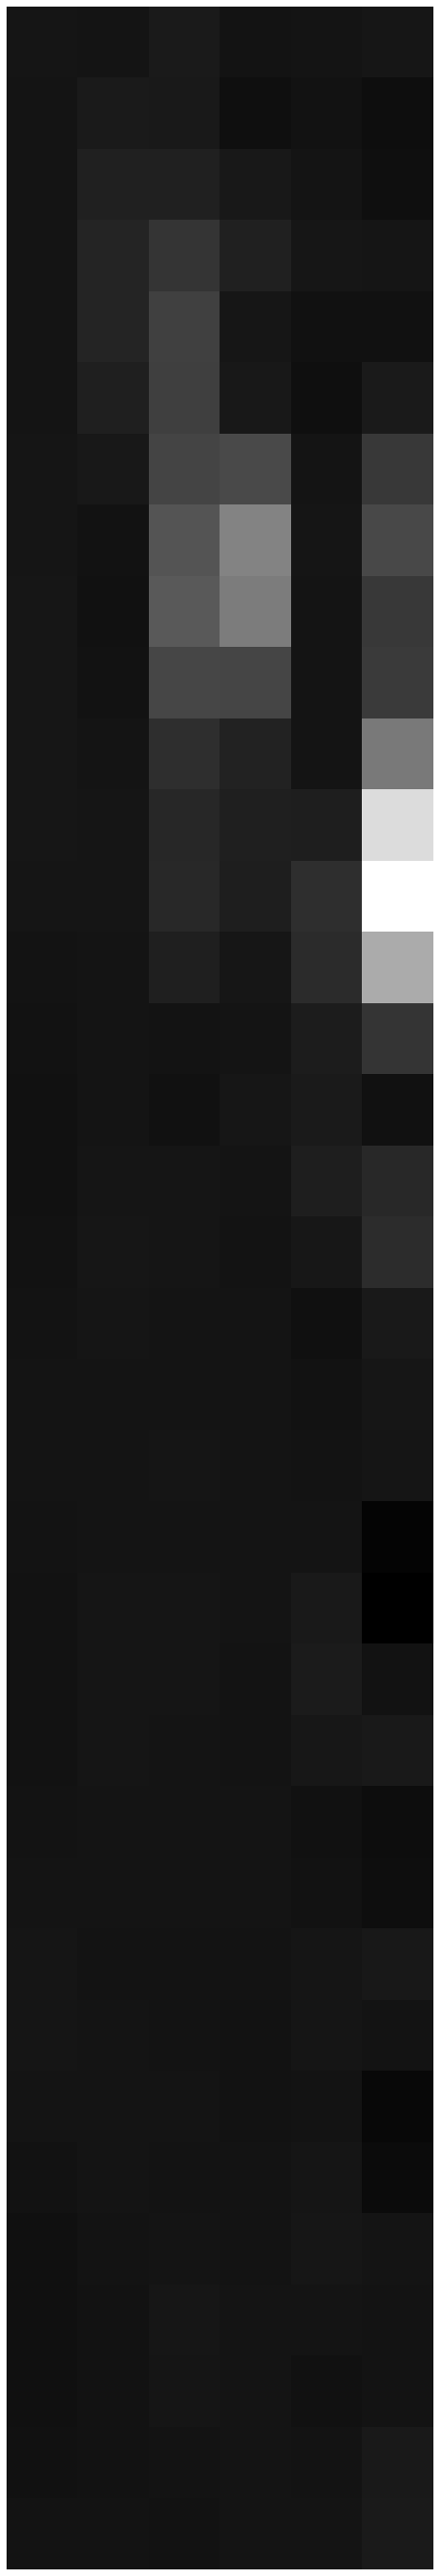

In [ ]:
plt.imshow(x_data[1], cmap="gray")
plt.axis("off")
plt.savefig('timeseriesImageBefore.png', dpi=100)

# 36 X 36 x 3 Time series image

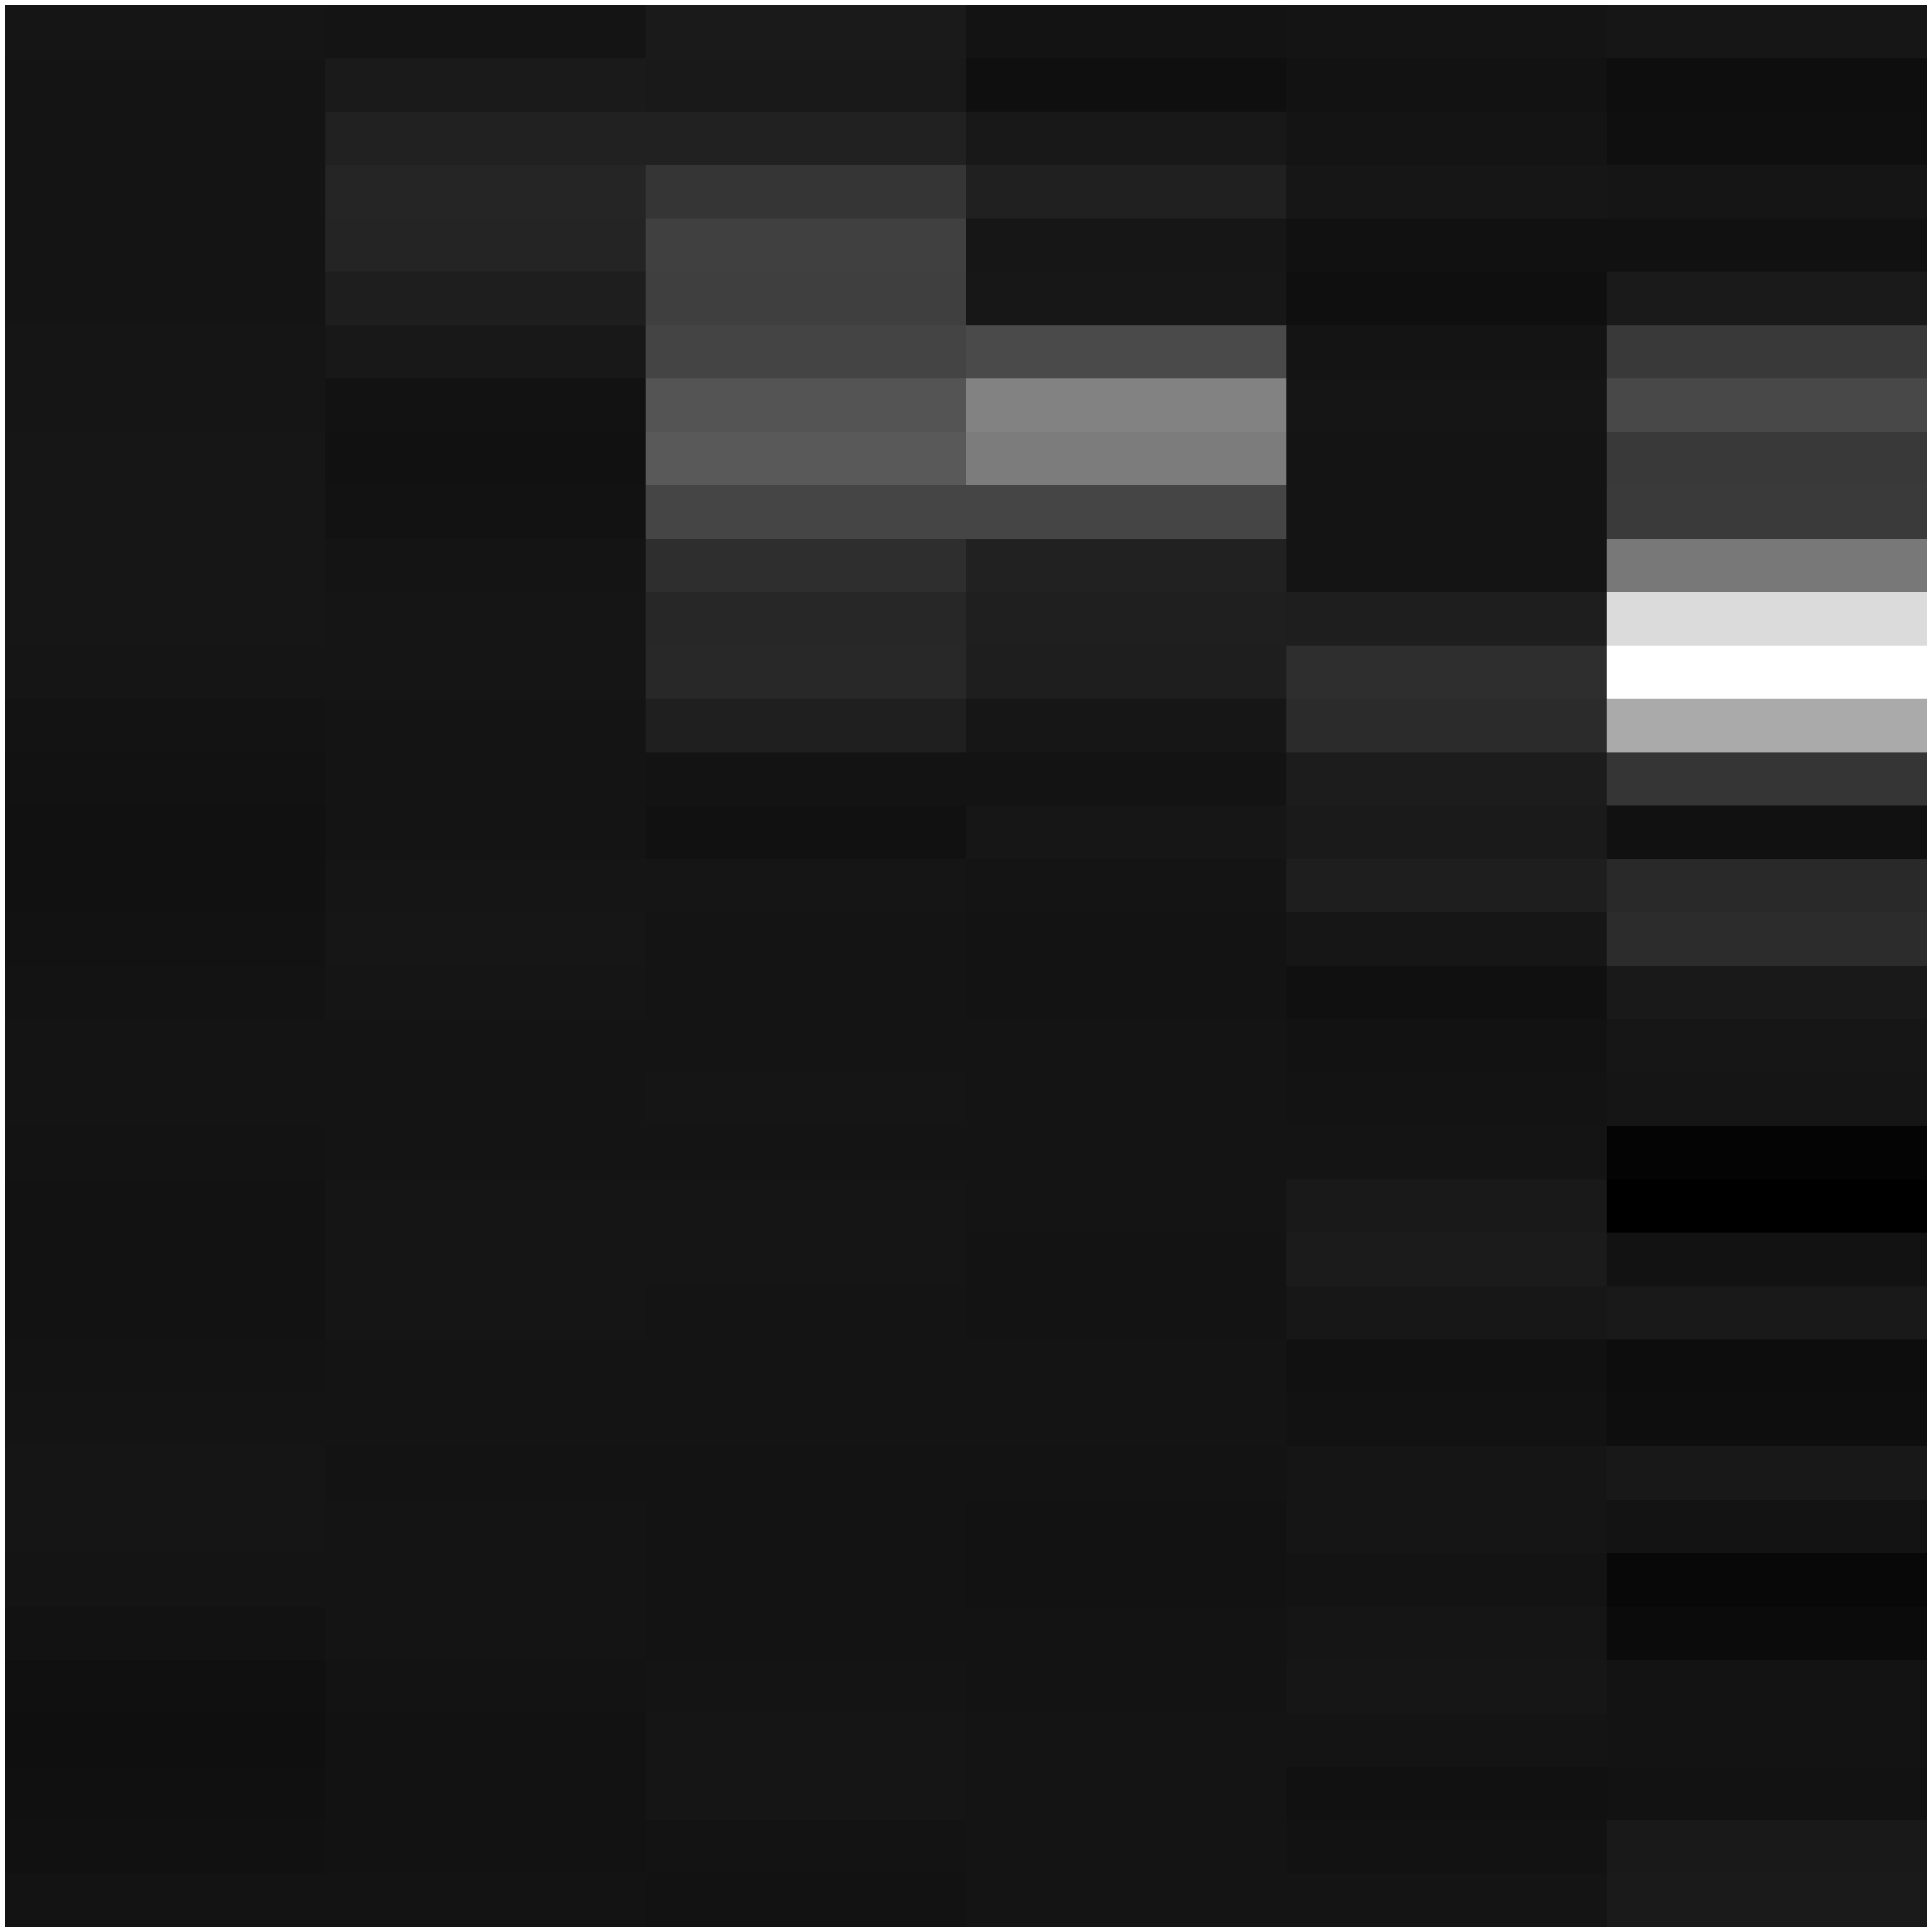

In [ ]:
plt.imshow(X_train1[1]/255)
plt.axis("off")
plt.savefig('timeseriesImageAfter.png', dpi=100)

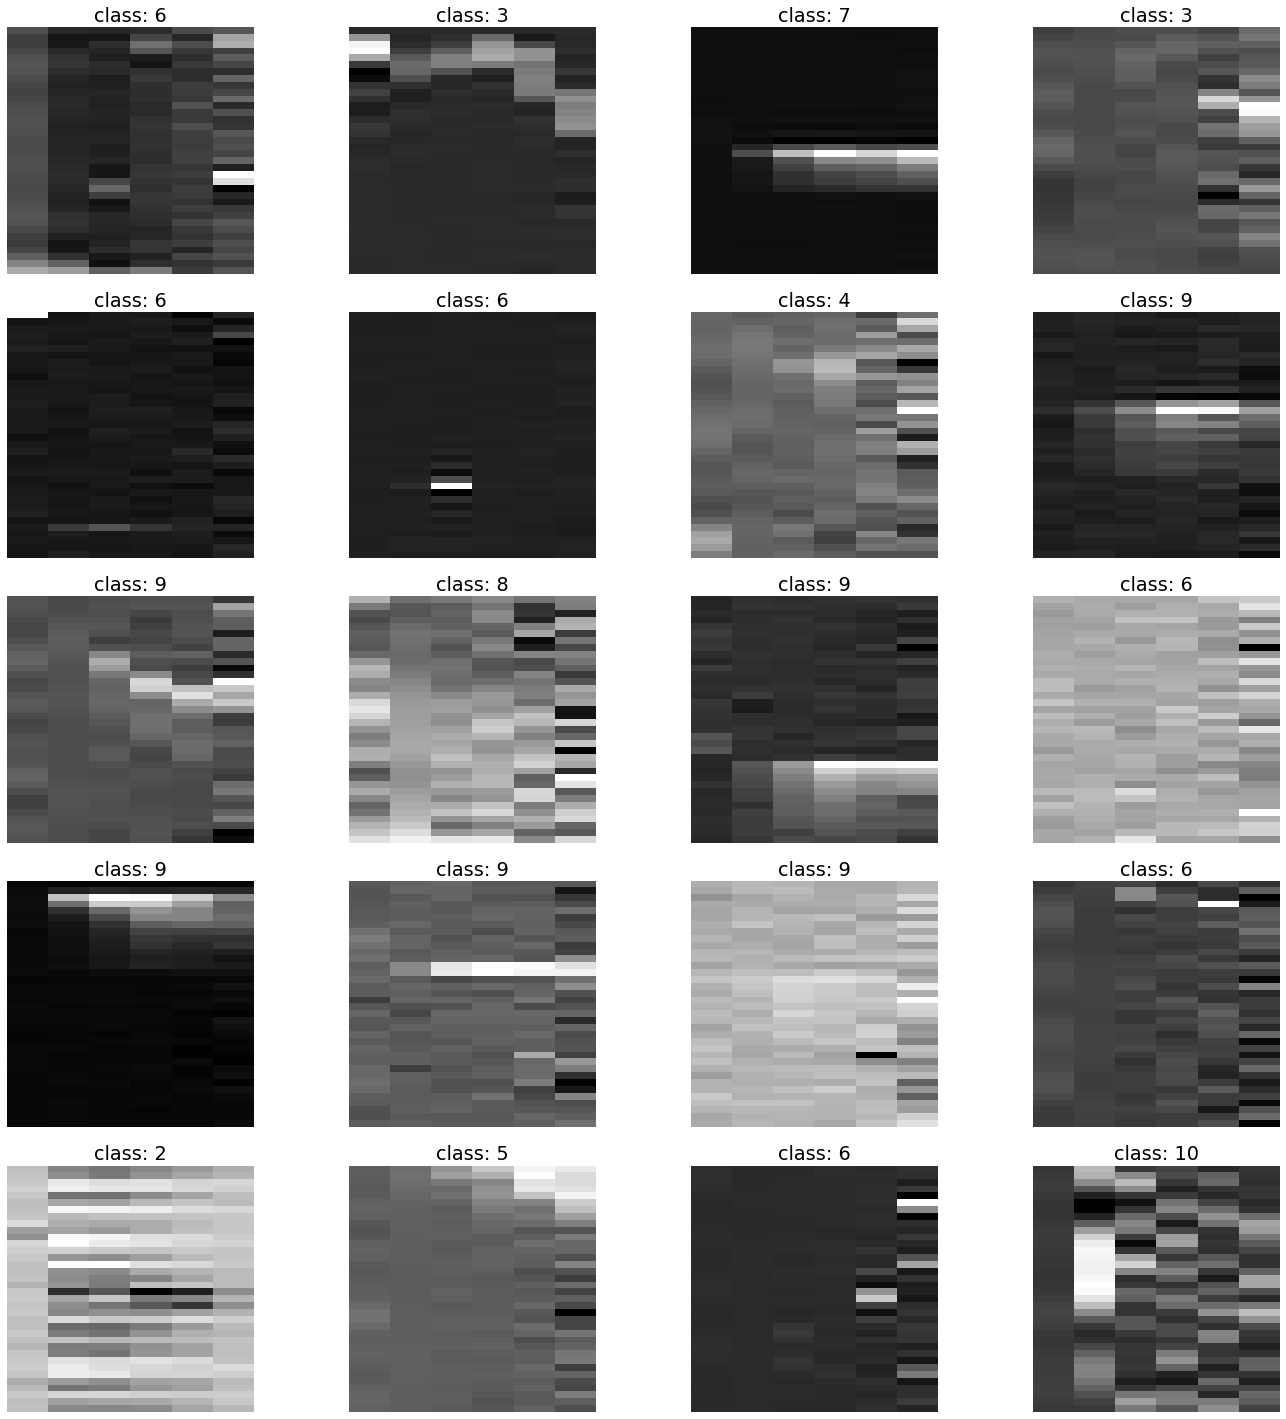

In [ ]:
num_img = 20

fig, axes = plt.subplots(5, num_img//5, figsize=(20,num_img))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    ax.imshow(X_test1[i]/255)
    ax.title.set_text("class: " + str(y_test[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Tensorflow Dataset to handle the 2 types of inputs

In [ ]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000000
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
val_dataset= val_dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)



train_dataset1 = tf.data.Dataset.from_tensor_slices(({'input1': X_train1, 'input2': X_train}, y_train))
test_dataset1 = tf.data.Dataset.from_tensor_slices(({'input1': X_test1, 'input2': X_test},y_test))
val_dataset1 = tf.data.Dataset.from_tensor_slices(({'input1': X_val1, 'input2': X_val},y_val))
train_dataset1 = train_dataset1.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE)
test_dataset1 = test_dataset1.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
val_dataset1 = val_dataset1.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)

# Cyclical LR

Cyclical learning rate (CLR) is a technique used in deep learning that involves varying the learning rate of the optimizer during training. Instead of using a fixed learning rate throughout the entire training process, the learning rate is gradually increased and then decreased in a cyclical manner. This technique was introduced by Leslie N. Smith in 2015.

The idea behind CLR is to allow the model to explore a wider range of learning rates and find the optimal learning rate for the given problem. This is achieved by gradually increasing the learning rate from a lower bound to an upper bound and then decreasing it back to the lower bound. This cycle can be repeated multiple times during the training process.

The benefits of CLR include faster convergence to the optimal solution and better generalization performance of the model. It can also help prevent the model from getting stuck in local minima by allowing it to escape to a different part of the loss landscape.

CLR can be implemented using various techniques, including triangular learning rate policy, triangular2 learning rate policy, and exponential learning rate policy. These policies differ in how the learning rate is varied over each cycle. The choice of policy depends on the specific problem and the architecture of the model being trained.

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# Convnext, vision-based

In [ ]:
input_shape = (36, 36, 3)
classes = y_train.shape[-1]
epochs = 1000

## Class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train),y = y_train)

## Supernet instantiation

In [ ]:
supernet1 = tf.keras.applications.convnext.ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)



count = 1
print(len(supernet1.layers))
for layer in supernet1.layers:
    if count < 80:
        layer.trainable = False
    else:
        layer.trainable = True
    count += 1

supernet1.summary()

print(count)

295
Model: "convnext_large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_large_prestem_normali  (None, 224, 224, 3)  0          ['input_3[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_large_stem (Sequentia  (None, 56, 56, 192)  9792       ['convnext_large_prestem_normaliz
 l)                                                              ation[0][0]']   

## CNN Architecture

In [ ]:
from keras import regularizers

input1 = tfk.Input((36,36,3), name = 'input1')
input2 = tfk.Input((36,6), name='input2')

# RESIZING
x = tfkl.Resizing(224,224,interpolation = "bicubic")(input1)
x = supernet1(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
convFeatures = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed))(convFeatures)
outputs = tf.keras.layers.Dense(12, activation='softmax', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


model = tfk.Model(inputs=[input1, input2], outputs=outputs, name='model1')
model.compile(loss=SparseCategoricalFocalLoss(class_weight = class_weights, gamma=1.5), optimizer=tfk.optimizers.Adam(learning_rate = 1e-4), metrics='accuracy')

model.summary()

Model: "model1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 36, 36, 3)]  0           []                               
                                                                                                  
 resizing_2 (Resizing)          (None, 224, 224, 3)  0           ['input1[0][0]']                 
                                                                                                  
 convnext_large (Functional)    (None, 7, 7, 1536)   196230336   ['resizing_2[0][0]']             
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1536)        0           ['convnext_large[0][0]']         
 obalAveragePooling2D)                                                                       

## CNN Training

In [ ]:
#Train the model
training_samples = int(X_train.shape[0])
step_size = 4*training_samples // 8

clr = CyclicLR(
    mode='triangular',
    base_lr=1e-6, 
    max_lr=1e-5,
    step_size= step_size)



history = model.fit(
    train_dataset1,
    epochs = 5,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True), clr
    ]
).history

# CNN time series-based

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input1 = tfk.Input((36,36,3), name = 'input1')
    input2 = tfk.Input((36,6), name='input2')

    # Feature extractor
    cnn = tfkl.Conv1D(512,5,padding='same',activation='relu')(input2)
    cnn = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.1, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)

    output_layer = tfkl.Dense(12, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=[input1, input2], outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=SparseCategoricalFocalLoss(class_weight = class_weights , gamma=2), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

## CNN Training

In [ ]:
model2 =build_1DCNN_classifier(input_shape, classes)
model2.summary()

training_samples = int(X_train.shape[0])
step_size = 4*training_samples // 8

clr = CyclicLR(
        mode='triangular',
        base_lr=1e-6,
    max_lr=1e-5,
        step_size= step_size)

history = model2.fit(
        train_dataset1,
        epochs = 10,
        validation_data=val_dataset1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True), clr
        ]
).history

In [ ]:
import gc
tf.keras.backend.clear_session()

gc.collect()

26915

# Ensemble (Average based) of Vision CNN & Time-series CNN

In [ ]:
models = [model, model2]
input1 = tfk.Input((36,36,3), name = 'input1')
input2 = tfk.Input((36,6), name='input2')
model_outputs = [model([input1, input2]) for model in models]
ensemble_output = tfkl.Average()(model_outputs)
ensemble_model = tfk.Model(inputs=[input1, input2], outputs=ensemble_output, name="ciao")
ensemble_model.compile(loss=SparseCategoricalFocalLoss(gamma=2), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

In [ ]:
ensemble_model.save("models/Ensemble.h5")

## Computing metrics (this was done before training on the whole dataset)

Standalone models performance

In [ ]:
# Predict the test set 
predictions1 = model.evaluate(test_dataset1)
predictions2 = model2.evaluate(test_dataset1)

31/31 [==============================] - 0s 3ms/step - loss: 1.3503 - accuracy: 0.7140


## Test-time augmentation

In [ ]:
def apply_aug(x, aug):
    xaug = np.empty_like(x)
    for i in range(x.shape[0]):
      s = np.expand_dims(x[i], axis = 0)
      xaug[i] = aug(s)

    return xaug

def combine_predictions(predictions):
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=-1)
    return preds

def prepare1d(array):
  array = scalerSampleWise(array)
  return normalizerSampleWise(array)

def combinedPred(m, x_test, augmentation=None):

    x_test = apply_aug(x_test, augmentation) if augmentation is not None else x_test
    x_test_1d = prepare1d(x_test)
    x_test_2d = timeSeriesToImage(x_test)
    X = (x_test_2d, x_test_1d)

    return m.predict(X)

def tta_predict(m, x_test):

    pred1 = combinedPred(m, x_test)
    pred2 = combinedPred(m, x_test, jitter)
    pred3 = combinedPred(m, x_test, scaling)
    pred4 = combinedPred(m, x_test, time_warp)
    pred5 = combinedPred(m, x_test, window_slice)
    pred6 = combinedPred(m, x_test, window_warp)
    pred7 = combinedPred(m, x_test, magnitude_warp)

    out = combine_predictions(np.stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7)))
    return out

predictions = tta_predict(ensemble_model, X_test)

16/16 [==============================] - 2s 117ms/step


## Ensemble model performance (No TTA)

In [ ]:
predictions = ensemble_model.evaluate(test_dataset1)

31/31 [==============================] - 8s 77ms/step - loss: 0.5573 - accuracy: 0.7716


## Ensemble model performance (TTA)

In [ ]:
accuracy = accuracy_score(y_test, predictions)

In [ ]:
accuracy

0.7901234567901234

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Loading model and prediction

Standalone code to load and perform inference

In [ ]:
import os
import tensorflow as tf
import itertools
import numpy as np

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'Ensemble.h5'),custom_objects={'LayerScale': LayerScale,'Custom>SparseCategoricalFocalLoss': SparseCategoricalFocalLoss})

    def jitter(self, x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
      return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

    def scaling(self, x, sigma=0.1):
        # https://arxiv.org/pdf/1706.00527.pdf
        factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
        return np.multiply(x, factor[:,np.newaxis,:])


    def time_warp(self, x, sigma=0.2, knot=4):
        from scipy.interpolate import CubicSpline
        orig_steps = np.arange(x.shape[1])

        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
        warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T

        ret = np.zeros_like(x)
        for i, pat in enumerate(x):
            for dim in range(x.shape[2]):
                time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
                scale = (x.shape[1]-1)/time_warp[-1]
                ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
        return ret


    def window_slice(self, x, reduce_ratio=0.9):
        # https://halshs.archives-ouvertes.fr/halshs-01357973/document
        target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
        if target_len >= x.shape[1]:
            return x
        starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
        ends = (target_len + starts).astype(int)

        ret = np.zeros_like(x)
        for i, pat in enumerate(x):
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
        return ret

    def window_warp(self, x, window_ratio=0.1, scales=[0.5, 2.]):
        # https://halshs.archives-ouvertes.fr/halshs-01357973/document
        warp_scales = np.random.choice(scales, x.shape[0])
        warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
        window_steps = np.arange(warp_size)

        window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
        window_ends = (window_starts + warp_size).astype(int)

        ret = np.zeros_like(x)
        for i, pat in enumerate(x):
            for dim in range(x.shape[2]):
                start_seg = pat[:window_starts[i],dim]
                window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
                end_seg = pat[window_ends[i]:,dim]
                warped = np.concatenate((start_seg, window_seg, end_seg))
                ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
        return ret

    def magnitude_warp(self, x, sigma=0.2, knot=4):
        from scipy.interpolate import CubicSpline
        orig_steps = np.arange(x.shape[1])

        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
        warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
        ret = np.zeros_like(x)
        for i, pat in enumerate(x):
            warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
            ret[i] = pat * warper

        return ret

    def apply_aug(self, x, aug):

        xaug = np.empty_like(x)
        for i in range(x.shape[0]):
          s = np.expand_dims(x[i], axis = 0)
          xaug[i] = aug(s)

        return xaug

    def combine_predictions(self, predictions):
        pred_agg = np.mean(predictions, axis=0)
        preds = np.argmax(pred_agg, axis=-1)
        return preds

    def shifter0255(self, array):
            for i in range(array.shape[0]):
                flattened = array[i].flatten()
                shifted = np.interp(flattened, (flattened.min(), flattened.max()), (0, 255))
                array[i] = np.reshape(shifted, array[i].shape)
    def timeSeriesToImage(self, x):
            x = np.repeat(x, repeats = 6, axis = 2)
            shifter0255(x)
            x = np.stack([x, x, x], axis = -1)
            return x


    def scalerSampleWise(self, array):
      for i in range(array.shape[0]):
        max = array[i].max()
        min = array[i].min()

        array[i] = (array[i]-min)/(max-min)

      return array

    def normalizerSampleWise(self, array):
      for i in range(array.shape[0]):
        mean = array[i].mean()
        std = array[i].std()

        array[i] = (array[i]-mean)/std

      return array

    def prepare1d(array):
      array = scalerSampleWise(array)
      return normalizerSampleWise(array)


    def combinedPred(self, m, x_test, augmentation=None):

        x_test = apply_aug(x_test, augmentation) if augmentation is not None else x_test
        x_test_1d = prepare1d(x_test)
        x_test_2d = timeSeriesToImage(x_test)

        X = (x_test_2d, x_test_1d)

        return m.predict(X)

    def tta_predict(self, m, x_test):

        pred1 = combinedPred(m, x_test)
        pred2 = combinedPred(m, x_test, self.jitter)
        pred3 = combinedPred(m, x_test, self.scaling)
        pred4 = combinedPred(m, x_test, self.time_warp)
        pred5 = combinedPred(m, x_test, self.window_slice)
        pred6 = combinedPred(m, x_test, self.window_warp)
        pred7 = combinedPred(m, x_test, self.magnitude_warp)

        out = combine_predictions(np.stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7)))
        return out

    def predict(self, X):

        X_np = X.numpy()
        out = tta_predict(self.model, X_np)
        out = tf.convert_to_tensor(out)

        return out

class LayerScale(tf.keras.layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

_EPSILON = tf.keras.backend.epsilon()

def sparse_categorical_focal_loss(y_true, y_pred, gamma, *,
                                  class_weight = None,
                                  from_logits: bool = False, axis: int = -1
                                  ) -> tf.Tensor:

    # Process focusing parameter
    gamma = tf.convert_to_tensor(gamma, dtype=tf.dtypes.float32)
    gamma_rank = gamma.shape.rank
    scalar_gamma = gamma_rank == 0

    # Process class weight
    if class_weight is not None:
        class_weight = tf.convert_to_tensor(class_weight,
                                            dtype=tf.dtypes.float32)

    # Process prediction tensor
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred_rank = y_pred.shape.rank
    if y_pred_rank is not None:
        axis %= y_pred_rank
        if axis != y_pred_rank - 1:
            # Put channel axis last for sparse_softmax_cross_entropy_with_logits
            perm = list(itertools.chain(range(axis),
                                        range(axis + 1, y_pred_rank), [axis]))
            y_pred = tf.transpose(y_pred, perm=perm)
    elif axis != -1:
        raise ValueError(
            f'Cannot compute sparse categorical focal loss with axis={axis} on '
            'a prediction tensor with statically unknown rank.')
    y_pred_shape = tf.shape(y_pred)

    # Process ground truth tensor
    y_true = tf.dtypes.cast(y_true, dtype=tf.dtypes.int64)
    y_true_rank = y_true.shape.rank

    if y_true_rank is None:
        raise NotImplementedError('Sparse categorical focal loss not supported '
                                  'for target/label tensors of unknown rank')

    reshape_needed = (y_true_rank is not None and y_pred_rank is not None and
                      y_pred_rank != y_true_rank + 1)
    if reshape_needed:
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, y_pred_shape[-1]])

    if from_logits:
        logits = y_pred
        probs = tf.nn.softmax(y_pred, axis=-1)
    else:
        probs = y_pred
        logits = tf.math.log(tf.clip_by_value(y_pred, _EPSILON, 1 - _EPSILON))

    xent_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=logits,
    )

    y_true_rank = y_true.shape.rank
    probs = tf.gather(probs, y_true, axis=-1, batch_dims=y_true_rank)
    if not scalar_gamma:
        gamma = tf.gather(gamma, y_true, axis=0, batch_dims=y_true_rank)
    focal_modulation = (1 - probs) ** gamma
    loss = focal_modulation * xent_loss

    if class_weight is not None:
        class_weight = tf.gather(class_weight, y_true, axis=0,
                                 batch_dims=y_true_rank)
        loss *= class_weight

    if reshape_needed:
        loss = tf.reshape(loss, y_pred_shape[:-1])

    return loss

class SparseCategoricalFocalLoss(tf.keras.losses.Loss):

    def __init__(self, gamma, class_weight = None,
                 from_logits: bool = False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.class_weight = class_weight
        self.from_logits = from_logits

    def get_config(self):
        config = super().get_config()
        config.update(gamma=self.gamma, class_weight=self.class_weight,
                      from_logits=self.from_logits)
        return config

    def call(self, y_true, y_pred):
        return sparse_categorical_focal_loss(y_true=y_true, y_pred=y_pred,
                                             class_weight=self.class_weight,
                                             gamma=self.gamma,
                                             from_logits=self.from_logits)

In [ ]:
m = model(path = "models/")

In [ ]:
X_test = "" # test data
preds = m.predict(tf.convert_to_tensor(X_test))

In [ ]:
accuracy = accuracy_score(y_test, preds)

In [ ]:
accuracy